<a href="https://colab.research.google.com/github/sainivas-99/License-Plate-Detection/blob/main/LPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install ultralytics -qq
!pip install easyocr -qq
!pip install GPUtil -qq
!pip install pytesseract -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.8/744.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [23]:
import os
import shutil
import glob
import yaml
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import ultralytics
from ultralytics import YOLO
from PIL import Image

import easyocr

import xml.etree.ElementTree as xet
from bs4 import BeautifulSoup

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import pytesseract

In [3]:
def make_folder(path):
    if not os.path.exists(path):
        os.mkdir(path)

def read_xml(file):
    labels = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    data = BeautifulSoup(file,"xml")
    d = dict()

    for label in labels:
        txt = data.find(label).text
        if all(c.isdigit() for c in txt):
            d[label] = int(txt)
        else:
            d[label] = txt
    return d

def xml_to_txt(path, height, width):

    with open(path, 'r') as f:
        txt = read_xml(f.read())

    xmin = int(txt['xmin'])
    ymin = int(txt['ymin'])
    xmax = int(txt['xmax'])
    ymax = int(txt['ymax'])

    x_center = (xmin+(xmax-xmin)/2)/width
    y_center = (ymin+(ymax-ymin)/2)/height

    w = (xmax-xmin)/width
    h = (ymax-ymin)/height

    return f'0 {x_center} {y_center} {w} {h}'

def view_folder_tree(path, indent=''):
    print(indent + os.path.basename(path) + '/')
    indent += '    '
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            view_folder_tree(item_path, indent)
        else:
            print(indent + item)

def show_image(img, print_info = True, hide_axis = False, figsize = (15,15), title=None):
    fig = plt.figure(figsize = figsize)
    if isinstance(img, str):  # Check if it's a file path
        img = Image.open(img)

        plt.imshow(img)
    elif isinstance(img, np.ndarray):  # Check if it's a NumPy array
        if img.shape[-1] == 3:
            img = img[..., ::-1]  # BGR to RGB
            img = Image.fromarray(img)
            plt.imshow(img)
        else:
            img = np.copy(img)
            plt.imshow(img,cmap = 'gray')

    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

In [ ]:
total_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/ML/datasets/images/*.png')

In [ ]:
np.random.seed(123)
indices = np.arange(len(total_images))
random.shuffle(indices)

train_size = int(0.7 * len(indices))
valid_size = int(0.1 * len(indices))
test_size = len(indices) - train_size - valid_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]


In [ ]:
make_folder('/content/drive/MyDrive/Colab Notebooks/ML/datasets/output')

In [ ]:
sets = ['train','valid','test']
dirs = ['images','labels']
for set in sets:
    path1 = '/content/drive/MyDrive/Colab Notebooks/ML/datasets/output'+f'/{set}'
    make_folder(path1)
    for dir in dirs:
        path2 = path1+f'/{dir}'
        make_folder(path2)
        print(path2)

/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/train/images
/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/train/labels
/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/valid/images
/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/valid/labels
/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/test/images
/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/test/labels


In [ ]:
for i, img_path in enumerate(total_images):
    if i in test_indices:
        dataset = 'test'
    elif i in val_indices:
        dataset = 'valid'
    else:
        dataset = 'train'
    dataset_type_path = '/content/drive/MyDrive/Colab Notebooks/ML/datasets/output'+f'/{dataset}'

    image = cv2.imread(img_path)
    img_height, img_width,_ = image.shape

    annotations_path = img_path.replace('images','annotations').replace('png','xml')
    boxes_info = xml_to_txt(annotations_path, img_height, img_width)

    img_file_name = img_path.split('/')[-1]
    txt_file_name = img_file_name.replace('.png','.txt')
    new_img_path = dataset_type_path+'/images/'+img_file_name
    new_label_path = dataset_type_path+'/labels/'+txt_file_name
    shutil.copy2(img_path, new_img_path)

    txt = open(new_label_path,"w")
    txt.write(boxes_info)
    txt.close()


In [ ]:
yaml_details =  {
                        'names' : ['vehicle_plate'],
                        'nc' : 1,
                        'train' : '/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/train',
                        'val' : '/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/valid',
                        'test' : '/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/test'
                }

with open('/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/plate.yaml','w+') as file:
    yaml.safe_dump(yaml_details, file)

with open('/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/plate.yaml','r') as file:
    plate_yaml = yaml.safe_load(file)


In [ ]:
license_plate_yolo = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 365MB/s]


In [ ]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    if num_gpus > 1:
      train_device, test_device = 0,1

    else:
      train_device, test_device = 0,0

    for i in range(num_gpus):
      gpu_properties = torch.cuda.get_device_properties(i)
      print(f"\nGPU {i}: {gpu_properties.name}")
      print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
      print(f"  CUDA Version: {gpu_properties.major}.{gpu_properties.minor}")

else:
    print('No GPUs. Using CPU')
    train_device, test_device = 'cpu', 'cpu'



Number of available GPUs: 1

GPU 0: Tesla T4
  Total Memory: 14.75 GB
  CUDA Version: 7.5


In [ ]:
license_plate_yolo.train(
    data = '/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/plate.yaml',
    task = 'detect',
    epochs = 50,
    batch = -1,
    val = True,
    seed = 42,
    lr0 = 1e-5,
    lrf = 0.01,
    dropout = 0.5,
    optimizer = 'auto',
    patience = 70,
    name = 'license plate',
    device = train_device
)

Ultralytics YOLOv8.1.39 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/plate.yaml, epochs=50, time=None, patience=70, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=license plate, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

100%|██████████| 755k/755k [00:00<00:00, 98.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 246MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.25G reserved, 0.11G allocated, 14.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11135987       28.65         0.367         25.08         121.1        (1, 3, 640, 640)                    list
    11135987       57.29         0.560         21.17         51.44        (2, 3, 640, 640)                    list
    11135987       114.6         1.065         29.07         57.28        (4, 3, 640, 640)                    list
    11135987       229.2         1.946         37.57         65.08        (8, 3, 640, 640)                    list
    11135987       458.4         3.634          72.5         94.84       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 38 for CUDA:0 8.83G/14.75G (60%) ✅


train: Scanning /content/drive/MyDrive/Colab Notebooks/ML/datasets/output/train/labels.cache... 303 images, 0 backgrounds, 0 corrupt: 100%|██████████| 303/303 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/ML/datasets/output/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]


Plotting labels to runs/detect/license plate/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00059375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/license plate
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.16G       1.88      16.89      1.605         79        640: 100%|██████████| 8/8 [00:16<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.87s/it]

                   all         43         43      0.012     0.0233    0.00126   0.000507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.19G      1.649      15.02      1.486         72        640: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         43         43     0.0833      0.116     0.0612      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.27G      1.381      3.645      1.178         74        640: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         43         43      0.022      0.465       0.11     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.27G      1.439        2.5      1.293         66        640: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         43         43    0.00408       0.86    0.00408    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.27G      1.428      1.441       1.22         72        640: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         43         43       0.05      0.395     0.0523     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.27G      1.453       1.28      1.313         59        640: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         43         43    0.00965      0.483    0.00782      0.003



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.27G      1.477      1.196      1.313         78        640: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         43         43     0.0137     0.0233    0.00774     0.0013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.12G      1.471      1.165      1.293         65        640: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         43         43     0.0137     0.0233    0.00774     0.0013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.11G      1.451      1.135       1.34         64        640: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         43         43   0.000704     0.0233   0.000168   4.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.11G      1.526       1.15      1.363         71        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         43         43    0.00388     0.0233     0.0012   0.000402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.11G       1.42      1.032      1.283         67        640: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         43         43    0.00487      0.186    0.00181   0.000594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.11G      1.444      1.004      1.338         71        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         43         43      0.254       0.14      0.099     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.11G      1.368      1.041      1.309         66        640: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         43         43      0.609      0.581       0.57      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.11G      1.361          1      1.269         65        640: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         43         43      0.415      0.256      0.284      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.11G       1.38     0.9516      1.245         74        640: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         43         43      0.222      0.186      0.125      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.11G      1.373     0.9608      1.253         73        640: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         43         43        0.4      0.256      0.228      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.11G      1.385     0.9135      1.299         68        640: 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         43         43      0.668      0.419      0.395      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.11G      1.308     0.8753      1.246         68        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         43         43      0.782      0.583      0.678      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.11G       1.31     0.8947      1.271         70        640: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         43         43      0.898      0.698      0.782       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.11G      1.316     0.8472      1.253         72        640: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         43         43      0.961      0.569      0.793      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.11G      1.285     0.8333      1.213         68        640: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         43         43      0.929      0.613      0.852      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.11G      1.317     0.8169      1.268         82        640: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         43         43      0.938      0.705       0.87      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.11G      1.296      0.815      1.221         70        640: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         43         43      0.893      0.773      0.878      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.11G      1.245     0.7927      1.193         68        640: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         43         43      0.912      0.907      0.936      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.11G       1.28     0.8047       1.22         67        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         43         43      0.811      0.799      0.868      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.11G      1.213     0.7752      1.216         74        640: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         43         43      0.914      0.738      0.826      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.11G       1.17     0.7388      1.154         58        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         43         43      0.915      0.814      0.911      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.11G      1.181     0.7291      1.193         71        640: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         43         43      0.965       0.86      0.944      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.11G      1.158      0.698      1.158         73        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         43         43      0.895      0.884      0.938      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.11G      1.145     0.7058      1.153         83        640: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         43         43      0.929      0.914      0.982      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.11G      1.142     0.6986       1.15         77        640: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         43         43          1      0.895      0.984      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.11G      1.154     0.6758      1.153         69        640: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         43         43      0.871      0.884       0.96      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.11G      1.132     0.6819      1.166         66        640: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         43         43      0.909      0.953      0.971      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.11G      1.102      0.692      1.156         67        640: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         43         43      0.927      0.888      0.981      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.11G      1.089     0.6667      1.108         62        640: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         43         43      0.866      0.907      0.952      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.11G      1.087      0.658      1.103         69        640: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         43         43      0.951      0.901      0.964      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.11G      1.075     0.6421      1.115         57        640: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         43         43      0.965      0.907      0.969      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.11G      1.046     0.6136      1.103         68        640: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         43         43       0.93      0.923      0.964       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.11G       1.07     0.6377      1.119         71        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         43         43      0.914       0.93       0.97      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.11G     0.9649      0.581      1.068         65        640: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         43         43      0.929      0.907      0.981      0.641


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.11G      1.058     0.6053      1.105         37        640: 100%|██████████| 8/8 [00:11<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         43         43      0.974      0.883      0.966      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.11G      1.023     0.5899      1.097         37        640: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         43         43      0.974      0.857      0.965      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.11G      1.026      0.563      1.109         37        640: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         43         43      0.929          1      0.987      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.11G     0.9956     0.5499      1.117         37        640: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         43         43      0.926          1       0.99      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.11G     0.9578     0.5368      1.062         37        640: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         43         43      0.954      0.963      0.992       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.11G     0.9571     0.5171      1.079         37        640: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         43         43      0.976      0.956      0.993      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.11G       0.96     0.5219      1.081         37        640: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         43         43       0.97      0.977      0.992      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.11G     0.9111     0.5017      1.075         37        640: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         43         43      0.993      0.953      0.991      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.11G     0.9138     0.5093      1.042         36        640: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         43         43      0.994      0.953      0.993      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.11G     0.9084     0.4993      1.076         36        640: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         43         43      0.998      0.953      0.993      0.645



50 epochs completed in 0.113 hours.
Optimizer stripped from runs/detect/license plate/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/license plate/weights/best.pt, 22.5MB

Validating runs/detect/license plate/weights/best.pt...
Ultralytics YOLOv8.1.39 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


                   all         43         43      0.929          1      0.987      0.643
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/license plate


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2d81cd7430>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
shutil.move('/content/runs','/content/drive/MyDrive/Colab Notebooks/ML/datasets/output')

'/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/runs'

In [26]:
model = YOLO('/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/runs/detect/license plate/weights/best.pt')
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [4]:
path_to_folder = '/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/runs/detect/' + os.listdir('/content/drive/MyDrive/Colab Notebooks/ML/datasets/output' + '/runs/detect/')[-1]
view_folder_tree(path_to_folder)

license plate/
    args.yaml
    labels_correlogram.jpg
    labels.jpg
    train_batch0.jpg
    train_batch1.jpg
    train_batch2.jpg
    weights/
        last.pt
        best.pt
    train_batch321.jpg
    train_batch320.jpg
    train_batch322.jpg
    events.out.tfevents.1711922977.c5b7196c47a4.1118.0
    results.csv
    PR_curve.png
    val_batch0_labels.jpg
    val_batch0_pred.jpg
    F1_curve.png
    P_curve.png
    confusion_matrix_normalized.png
    R_curve.png
    confusion_matrix.png
    results.png


val_batch0_labels.jpg
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1920, 1920, 3) 



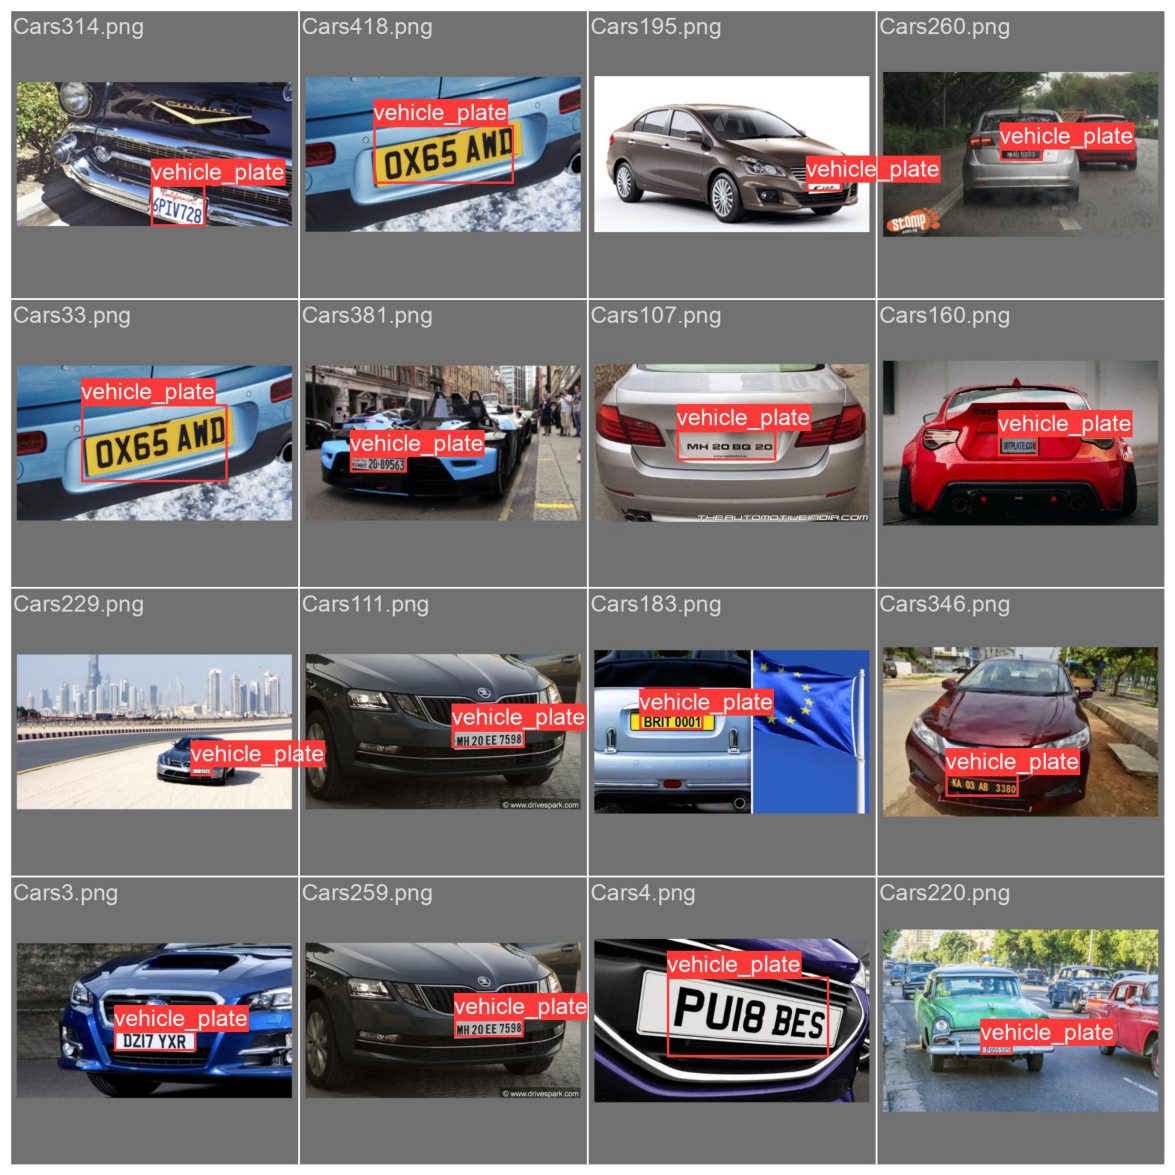

val_batch0_pred.jpg
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1920, 1920, 3) 



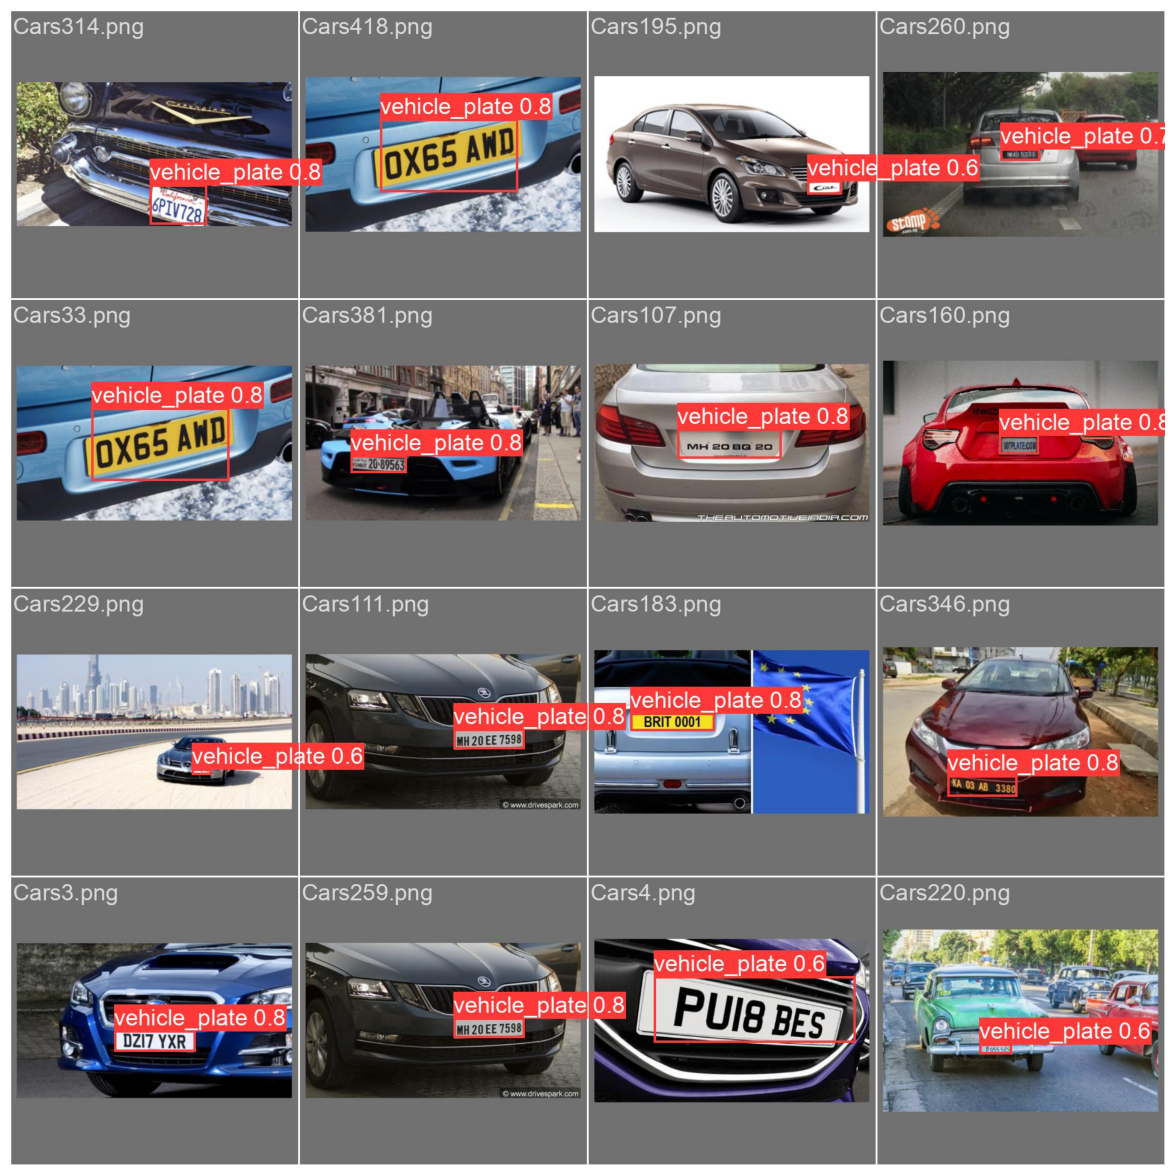

In [5]:
images_path = [f for f in os.listdir(path_to_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

batchs_plot = [f for f in images_path if 'val_batch' in f]
curves_plot = [f for f in images_path if 'curve' in f]

for path in batchs_plot:
    print(''.join(path.split('/')))
    show_image(os.path.join(path_to_folder,path), hide_axis = True)

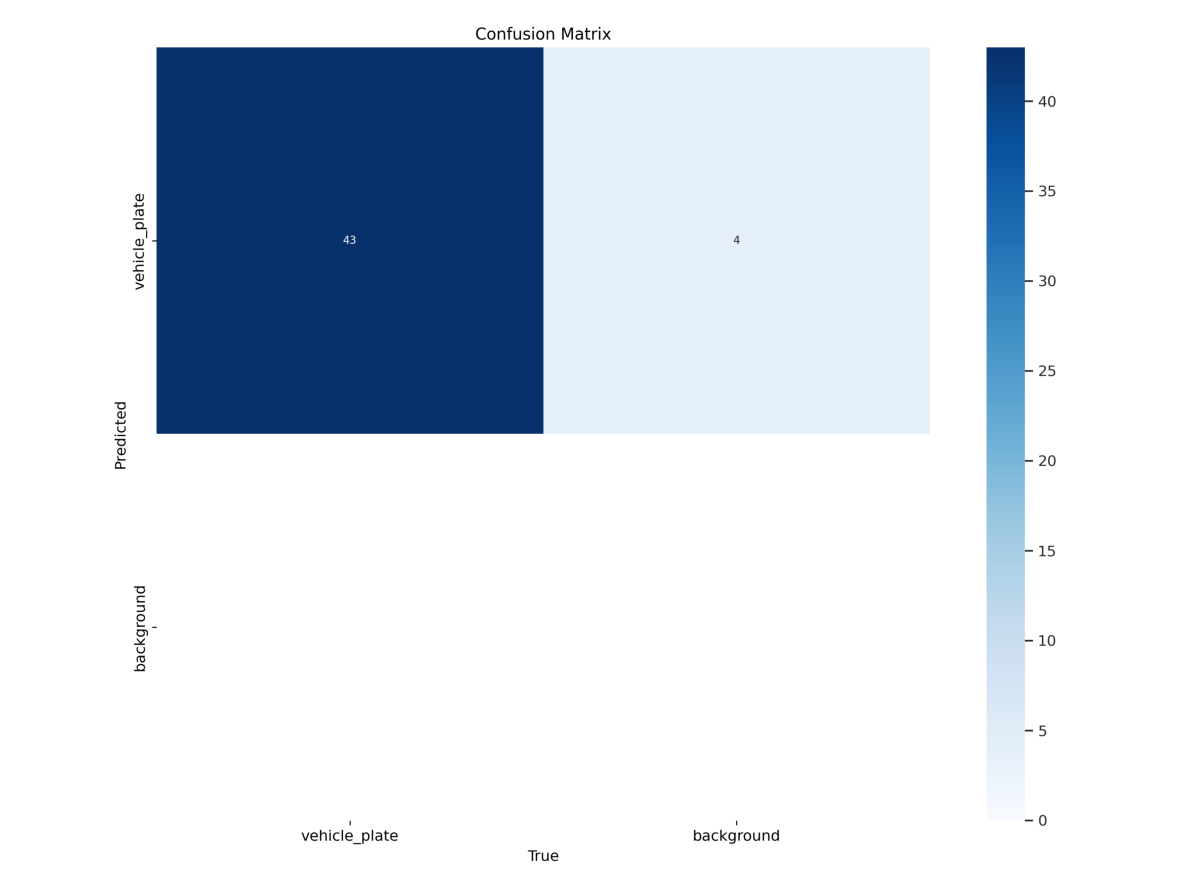

In [16]:
show_image('/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/runs/detect/license plate/confusion_matrix.png', hide_axis=True, print_info = False)

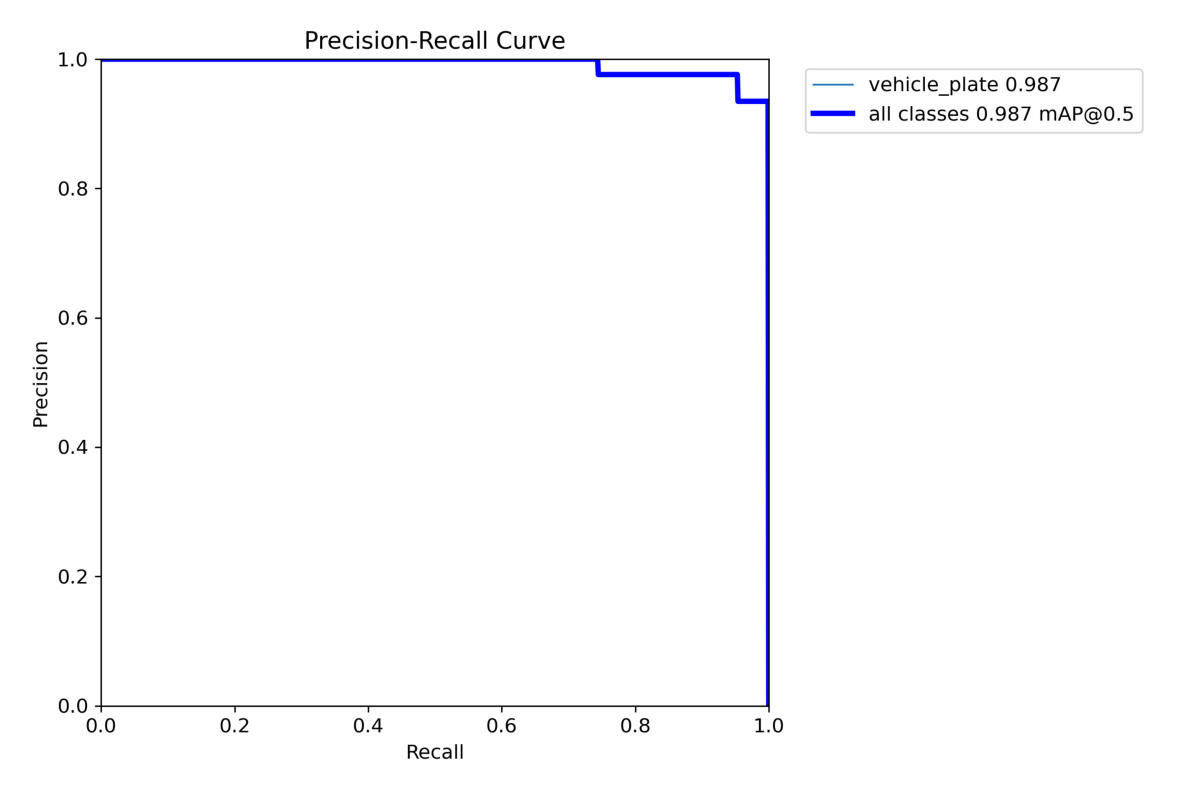

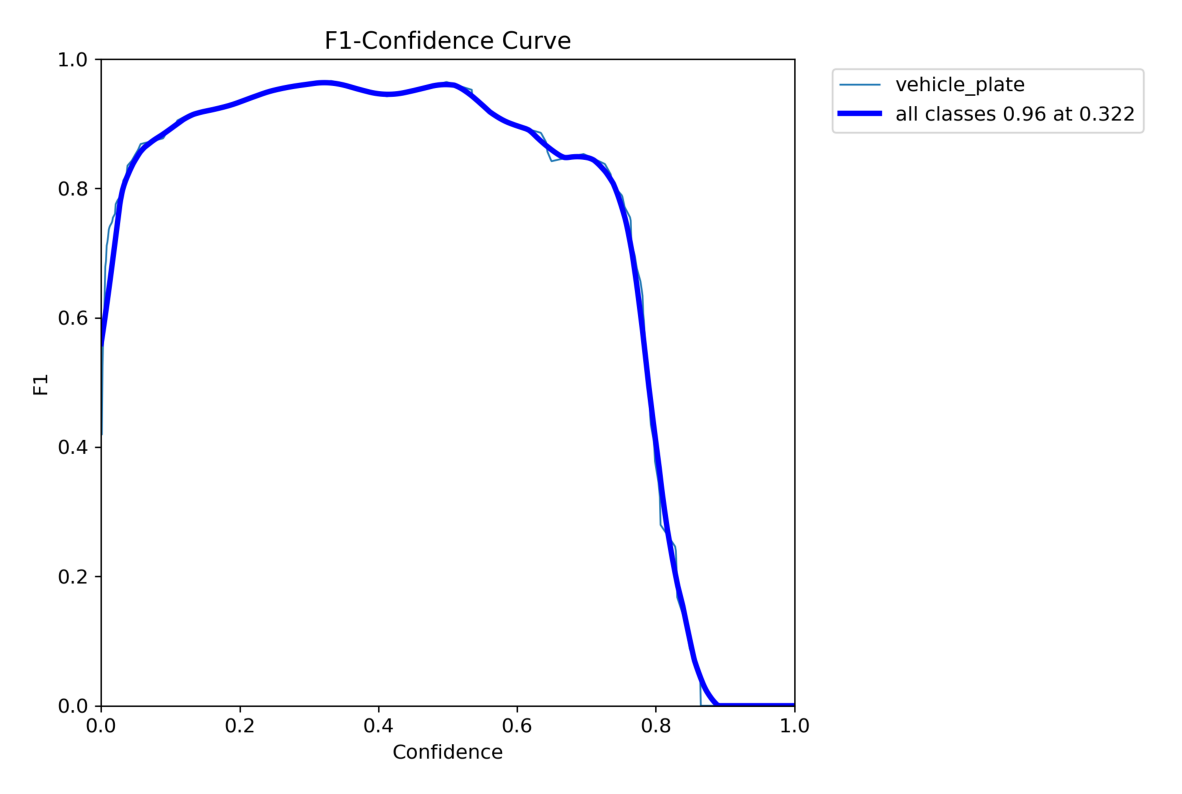

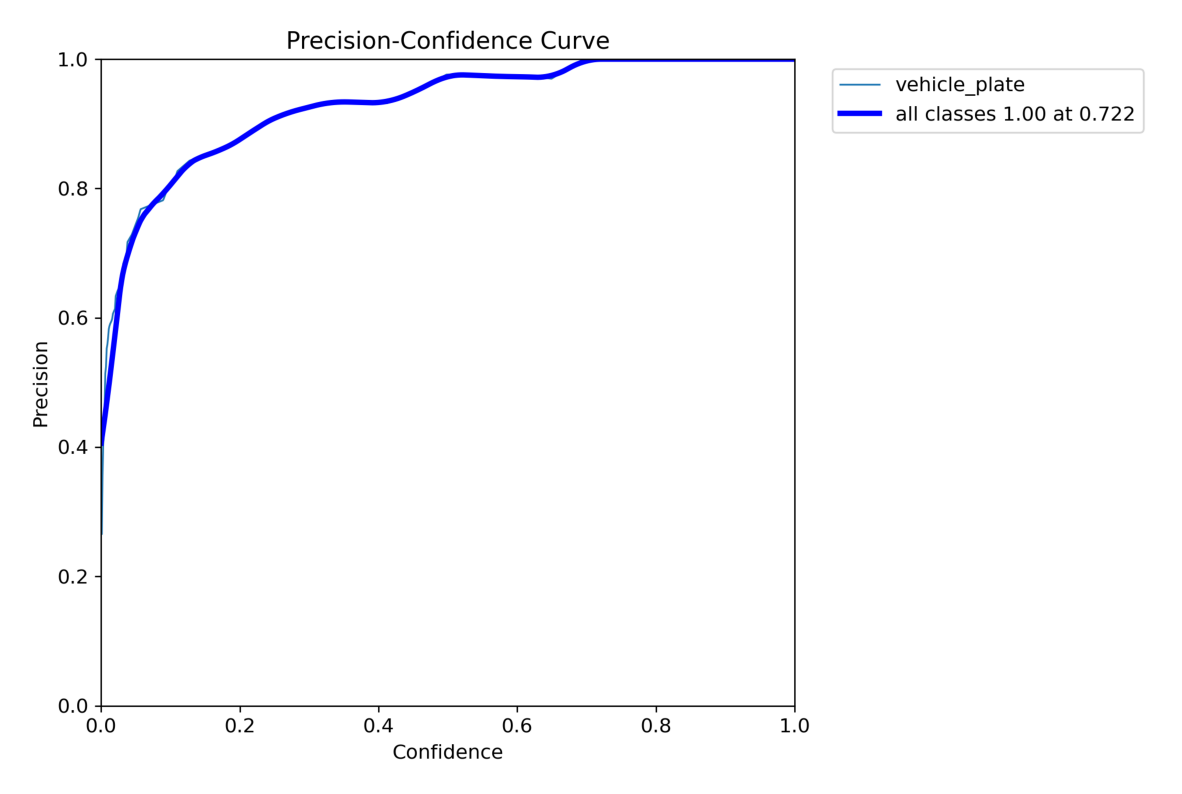

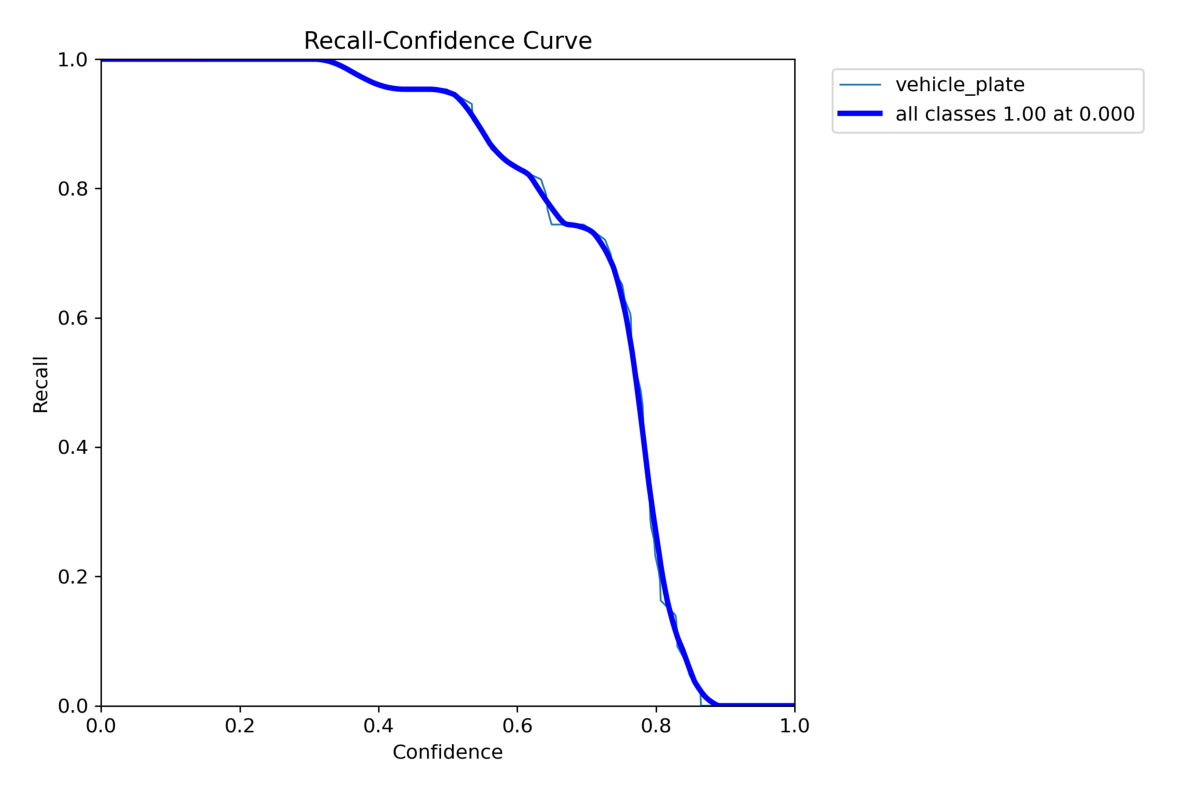

In [17]:
for plot in curves_plot:
    img_path = os.path.join(path_to_folder, plot)
    if os.path.exists(img_path):
      show_image(img_path, print_info = False, hide_axis= True)
    else:
      print('No such path found')

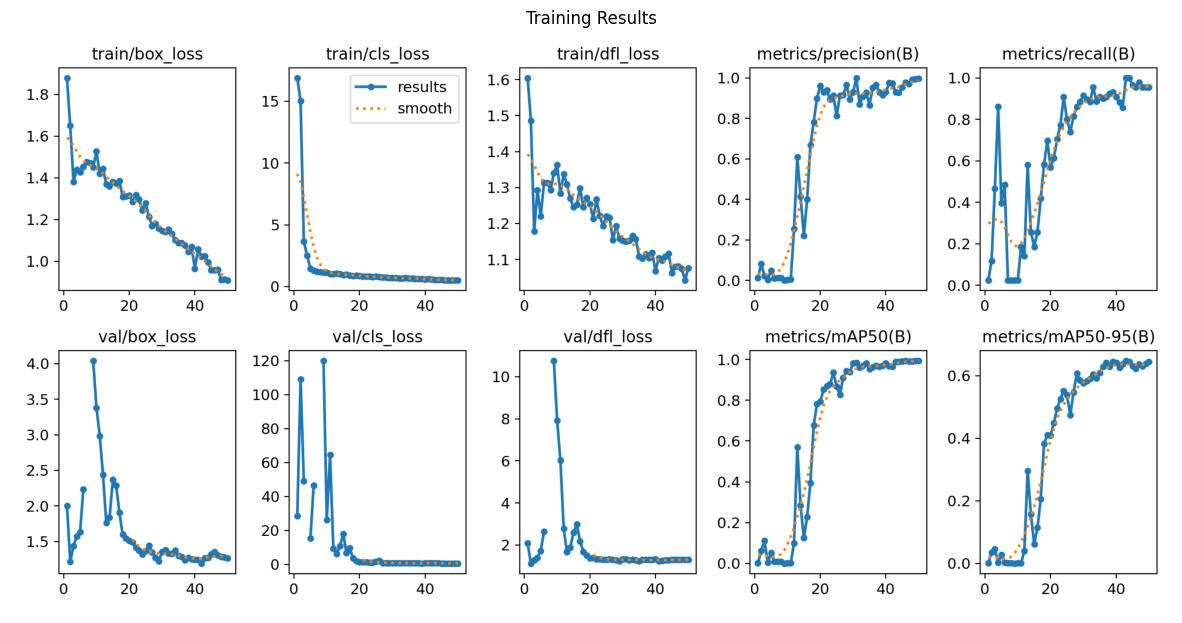

In [20]:
show_image('/content/drive/MyDrive/Colab Notebooks/ML/datasets/output/runs/detect/license plate/results.png', hide_axis= True, print_info= False, title='Training Results')